In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import ShuffleSplit
import glob

%matplotlib notebook

C:\Users\magme\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path_p1 = 'C:\\Users\\magme\\Documents\\censo escolar\\censo escolar\\micro_censo_escolar_'
path_p2 = '\\DADOS\\'
year = str(2017)
fp = path_p1 + year + '\\' + year + path_p2

In [3]:
file_name = fp + '\\MATRICULA_SUDESTE.CSV'
head1 = pd.read_csv(file_name, sep = '|', nrows = 5)

In [4]:
head1

,NU_ANO_CENSO,ID_MATRICULA,CO_PESSOA_FISICA,NU_DIA,NU_MES,NU_ANO,NU_IDADE_REFERENCIA,NU_IDADE,NU_DURACAO_TURMA,NU_DUR_ATIV_COMP_MESMA_REDE,...,IN_CONVENIADA_PP,TP_CONVENIO_PODER_PUBLICO,IN_MANT_ESCOLA_PRIVADA_EMP,IN_MANT_ESCOLA_PRIVADA_ONG,IN_MANT_ESCOLA_PRIVADA_SIND,IN_MANT_ESCOLA_PRIVADA_SIST_S,IN_MANT_ESCOLA_PRIVADA_S_FINS,TP_REGULAMENTACAO,TP_LOCALIZACAO_DIFERENCIADA,IN_EDUCACAO_INDIGENA
0,2017,220379144,127293731794,8,2,2012,5,5,255,0,...,1,3,0,0,0,0,1,1,0,0
1,2017,220379105,126092498455,15,3,2012,5,5,255,0,...,1,3,0,0,0,0,1,1,0,0
2,2017,220378197,126088535104,1,10,2012,4,5,255,0,...,1,3,0,0,0,0,1,1,0,0
3,2017,220379110,125943420508,26,12,2012,4,5,255,0,...,1,3,0,0,0,0,1,1,0,0
4,2017,220380963,124864710812,27,11,2011,5,6,255,0,...,1,3,0,0,0,0,1,1,0,0


In [129]:
columns = ['NU_ANO', 'TP_TIPO_TURMA', 'IN_REGULAR', 'TP_ETAPA_ENSINO', 'NU_ANO_CENSO', 'CO_PESSOA_FISICA', 'TP_SEXO',
           'TP_COR_RACA', 'CO_MUNICIPIO', 'TP_ZONA_RESIDENCIAL', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'IN_ESPECIAL_EXCLUSIVA']

In [190]:
years = [2016, 2017]
matriculas = pd.DataFrame()
for year in years:
    fp = path_p1 + str(year) + '\\' + str(year) + path_p2
    file_name = fp + '\\MATRICULA_SUDESTE.CSV'
    f_chunk = pd.DataFrame()
    iter_csv = pd.read_csv(file_name, sep = '|', encoding = 'latin1', usecols = columns,
                          iterator = True, chunksize = 15000)
    for chunk in iter_csv:
        chunk = chunk[chunk['CO_MUNICIPIO'] == 3303302]
        if chunk[chunk['TP_ETAPA_ENSINO'].isin([4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 41])].shape[0] == 0:
            continue
        chunk = chunk[~chunk['TP_TIPO_TURMA'].isin([4, 5])]
        #del chunk['TP_TIPO_TURMA']
        chunk = chunk[chunk['IN_REGULAR'] == 1]
        #del chunk['IN_REGULAR']
        chunk = chunk[chunk['IN_ESPECIAL_EXCLUSIVA'] == 0]
        #del chunk['IN_ESPECIAL_EXCLUSIVA']
        chunk['etapa'] = np.nan
        chunk.loc[chunk['TP_ETAPA_ENSINO'] == 14, 'etapa'] = 1 #first grade
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([4, 15]), 'etapa'] = 2 #second grades
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([5, 16]), 'etapa'] = 3 #...
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([6, 17]), 'etapa'] = 4
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([7, 18]), 'etapa'] = 5
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([8, 19]), 'etapa'] = 6
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([9, 20]),'etapa'] = 7
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([10, 21]),'etapa'] = 8
        chunk.loc[chunk['TP_ETAPA_ENSINO'].isin([11, 41]),'etapa'] = 9
        chunk = chunk.dropna(subset = ['etapa'])
        del chunk['TP_ETAPA_ENSINO']
        f_chunk = pd.concat([f_chunk, chunk])
        matriculas
        chunk['idade_calculada'] = chunk['NU_ANO_CENSO']  - chunk['NU_ANO'] 
        chunk['Anos_de_Atraso'] = chunk['NU_ANO'] - chunk['etapa'] - 5
        chunk = chunk[chunk['Anos_de_Atraso'] > -3]
        chunk = chunk[chunk['idade_calculada'] <= 17] #mantendo só alunos não aptos ao supletivo
        #del chunk['idade_calculada']
        f_chunk = pd.concat([f_chunk, chunk])
    matriculas = pd.concat([matriculas, f_chunk])
matriculas['idade_calculada'] = matriculas['NU_ANO_CENSO']  - matriculas['NU_ANO']
matriculas['Anos_de_Atraso'] = matriculas['idade_calculada'] - matriculas['etapa'] - 5
matriculas = matriculas[matriculas['Anos_de_Atraso'] > -3]
matriculas = matriculas[matriculas['idade_calculada'] <= 17] #mantendo só alunos não aptos ao supletivo
matriculas = matriculas[matriculas['TP_DEPENDENCIA'] == 3]

In [174]:
mm = matriculas.copy()

In [191]:
mmm = matriculas.copy()

In [192]:
try:
    del chunk
except:
    pass
try:
    del f_chunk
except:
    pass
matriculas = matriculas.drop_duplicates(subset = ['NU_ANO_CENSO', 'CO_PESSOA_FISICA']) #jogando fora pessoas que no mesmo ano 
                                                                                       #aparecem várias vezes
matriculas['Evasao'] = 0 #valor inicial de não evasao
matriculas['repeticoes'] = matriculas.groupby('CO_PESSOA_FISICA')['CO_PESSOA_FISICA']\
                           .transform('count') #conta quantas vezes a mesma pessoa aparece na amostra independente do ano
#del matriculas['CO_PESSOA_FISICA']
matriculas.loc[(matriculas['repeticoes'] == 1) & (matriculas['NU_ANO_CENSO'] == 2017), 'Evasao'] = 1 #se uma pessoa aparece só uma vez na amostra quer dizer que ela abandonou a escola em 2016
del matriculas['repeticoes']

In [193]:
matriculas.head()

,Anos_de_Atraso,CO_MUNICIPIO,CO_PESSOA_FISICA,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,NU_ANO,NU_ANO_CENSO,TP_COR_RACA,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_SEXO,TP_TIPO_TURMA,TP_ZONA_RESIDENCIAL,etapa,idade_calculada,Evasao
231084,2.0,3303302,122416481249,0.0,1.0,2005,2016,1,3,1,2,0,1,4.0,11,0
231085,1.0,3303302,121659669498,0.0,1.0,2006,2016,3,3,1,2,0,1,4.0,10,0
231086,1.0,3303302,121427324378,0.0,1.0,2006,2016,3,3,1,2,0,1,4.0,10,0
231087,5.0,3303302,119568471382,0.0,1.0,2002,2016,3,3,1,2,0,1,4.0,14,0
231088,0.0,3303302,119739497097,0.0,1.0,2007,2016,1,3,1,2,0,1,4.0,9,0


In [206]:
len(matriculas[(matriculas['NU_ANO_CENSO'] == 2017) & (matriculas['Evasao'] == 1) & (matriculas['TP_DEPENDENCIA'] == 3) &
              (matriculas['etapa'] != 9)])

4854

In [207]:
len(matriculas[(matriculas['NU_ANO_CENSO'] == 2017) & (matriculas['TP_DEPENDENCIA'] == 3) & (matriculas['etapa'] != 9)])

19000

In [188]:
4419/19953

0.2214704555705909

In [196]:
np.sort(matriculas['idade_calculada'].unique())

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17], dtype=int64)

In [197]:
np.sort(matriculas['Anos_de_Atraso'].unique())

array([-2., -1.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [154]:
m = matriculas.copy()

In [198]:
new_row = pd.DataFrame(0, index = ['Novos alunos/retornados'], columns = list(range(1, 10)) + ['Saiu do Sistema'])

In [199]:
transition = pd.DataFrame(0, index = range(1,10), columns = range(1,10)) #matrix for grades 1 thru 9
transition['Saiu do Sistema'] = 0 #column for students that left
transition = pd.concat([transition, new_row]) #adding new and returning students
transition

,1,2,3,4,5,6,7,8,9,Saiu do Sistema
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0
Novos alunos/retornados,0,0,0,0,0,0,0,0,0,0


In [201]:
mat = matriculas.copy()
for i in mat['CO_PESSOA_FISICA'].unique(): #for each unique student id
    try: #the row is going to be the grade the student was in 2016
        row = int(mat.loc[(mat['CO_PESSOA_FISICA'] == i) & (mat['NU_ANO_CENSO'] == 2016), 'etapa'])
    except: #if the student can't be found in 2016 then he's a new student
        row = 'Novos alunos/retornados'
    try: #the column is going to be the grade the student was in 2017
        column = int(mat.loc[(mat['CO_PESSOA_FISICA'] == i) & (mat['NU_ANO_CENSO'] == 2017), 'etapa'])
    except: #if the student can't be found in 2017 then he left
        column = 'Saiu do Sistema'
    transition.loc[row, column] += 1

In [202]:
totals = []
for i in transition.columns:
    totals += [np.sum(transition[i])]
total_row = pd.DataFrame([np.array(totals)], index = ['Total of 2017'], columns = list(range(1, 10)) + ['Saiu do Sistema'])
transition = pd.concat([transition, total_row])
transition['Total of 2016'] =  transition.sum(axis = 1)
transition.loc['Total of 2017', 'Total of 2016'] = 0

In [203]:
transition

,1,2,3,4,5,6,7,8,9,Saiu do Sistema,Total of 2016
1,301,2215,18,3,0,0,0,0,0,315,2852
2,2,130,2374,14,2,0,0,0,0,283,2805
3,4,0,627,2358,27,2,0,0,0,298,3316
4,0,2,0,84,2403,17,0,0,2,296,2804
5,0,0,2,3,232,1106,26,0,0,1588,2957
6,0,0,0,0,0,68,970,42,1,212,1293
7,0,0,0,0,0,15,283,776,22,245,1341
8,0,0,0,0,0,0,0,31,747,247,1025
9,1,0,0,1,0,4,0,3,59,701,769
Novos alunos/retornados,2627,440,414,369,360,313,189,142,123,0,4977


In [225]:
perc_transition = pd.DataFrame(0, index = range(1,10), columns = range(1,10)) #matrix for grades 1 thru 9
perc_transition['Saiu do Sistema'] = 0 #column for students that left
perc_transition = pd.concat([perc_transition, new_row]) 
for row in perc_transition.index:
    for column in transition.columns:
        value = transition.loc[row, column]/transition.loc[row, 'Total of 2016']
        if value < 0.01:
            continue
        perc_transition.loc[row, column] = value

In [226]:
perc_transition

,1,2,3,4,5,6,7,8,9,Saiu do Sistema,Total of 2016
1,0.105540,0.776648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110449,1.0
2,0.000000,0.046346,0.846346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100891,1.0
3,0.000000,0.000000,0.189083,0.711098,0.000000,0.000000,0.000000,0.000000,0.000000,0.089867,1.0
4,0.000000,0.000000,0.000000,0.029957,0.856990,0.000000,0.000000,0.000000,0.000000,0.105563,1.0
5,0.000000,0.000000,0.000000,0.000000,0.078458,0.374028,0.000000,0.000000,0.000000,0.537031,1.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.052591,0.750193,0.032483,0.000000,0.163960,1.0
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.011186,0.211037,0.578673,0.016406,0.182699,1.0
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030244,0.728780,0.240976,1.0
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.076723,0.911573,1.0
Novos alunos/retornados,0.527828,0.088407,0.083183,0.074141,0.072333,0.062889,0.037975,0.028531,0.024714,0.000000,1.0


In [223]:
perc_transition.loc[row, :'Saiu do Sistema']

1                  0.105540
2                  0.776648
3                  0.006311
4                  0.001052
5                  0.000000
6                  0.000000
7                  0.000000
8                  0.000000
9                  0.000000
Saiu do Sistema    0.110449
Name: 1, dtype: float64

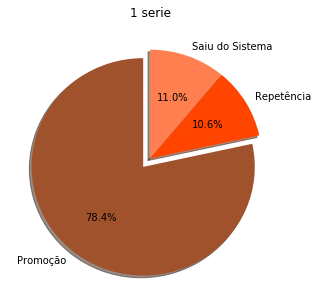

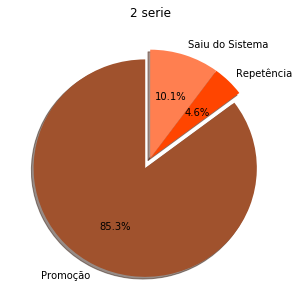

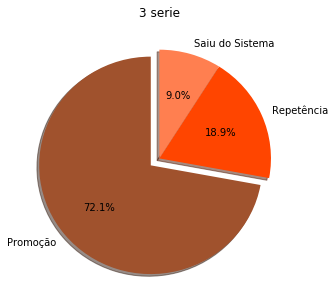

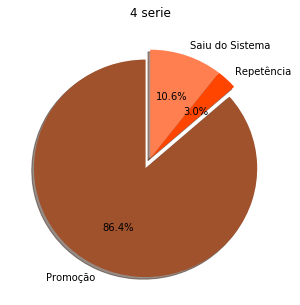

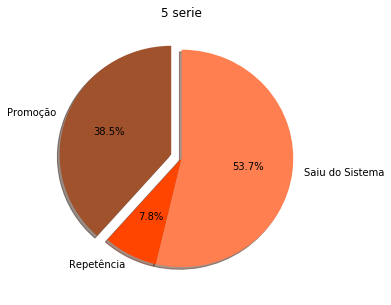

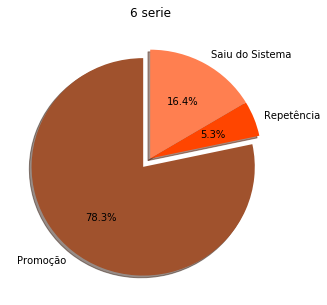

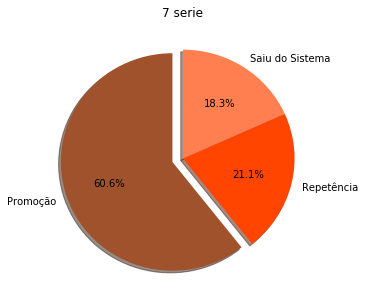

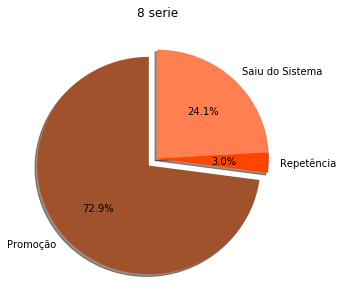

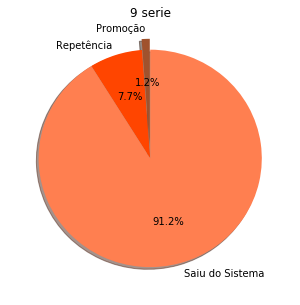

In [239]:
for row in perc_transition.index[:-1]:
    plt.figure(figsize = (5, 5))
    labels = ['Promoção', 'Repetência', 'Saiu do Sistema']
    colors = ['sienna', 'orangered', 'coral']
    rep = perc_transition.loc[row, row]
    ev = perc_transition.loc[row, 'Saiu do Sistema']
    prom = 1 - rep - ev
    values = [prom, rep, ev]
    explode = (0.1, 0, 0)
    plt.pie(values, labels = labels, colors = colors, 
            autopct='%1.1f%%', startangle = 90, shadow = True,
           explode = explode,)
    plt.title(str(row) + ' serie')
    plt.savefig('./graficos/' + str(row) + ' serie.png')
    plt.show()

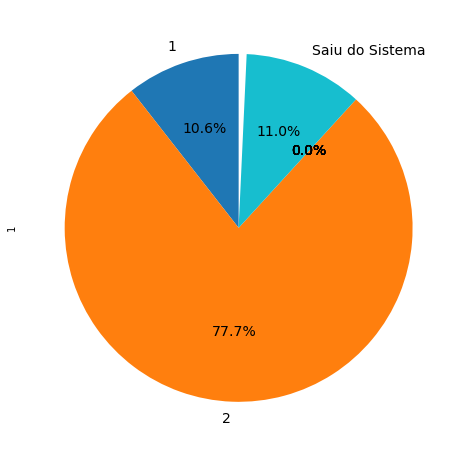

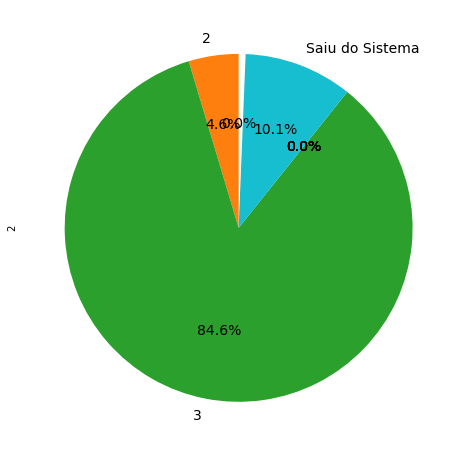

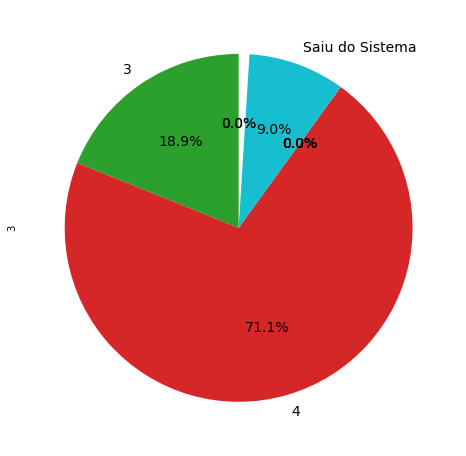

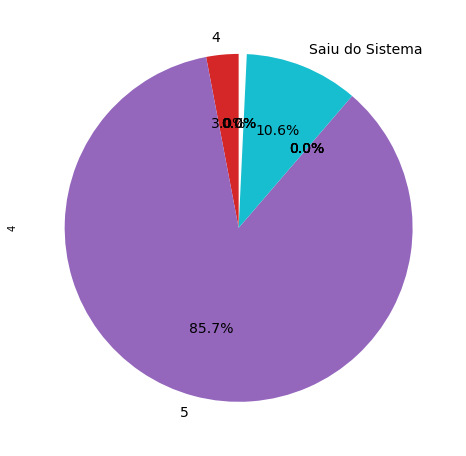

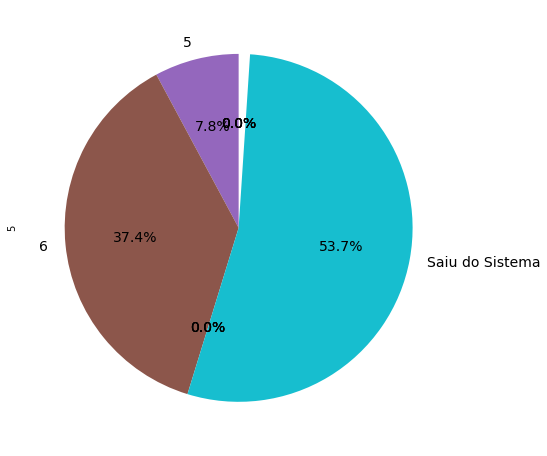

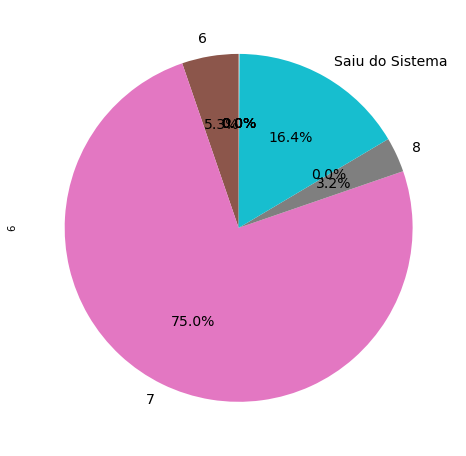

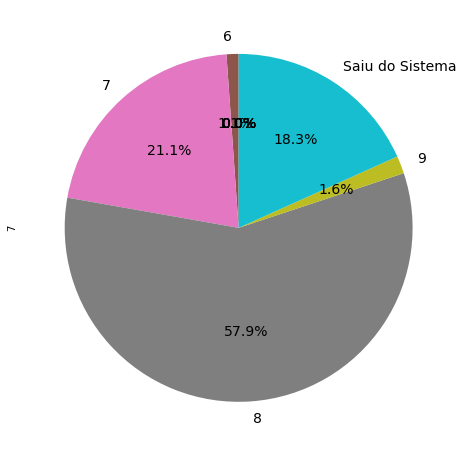

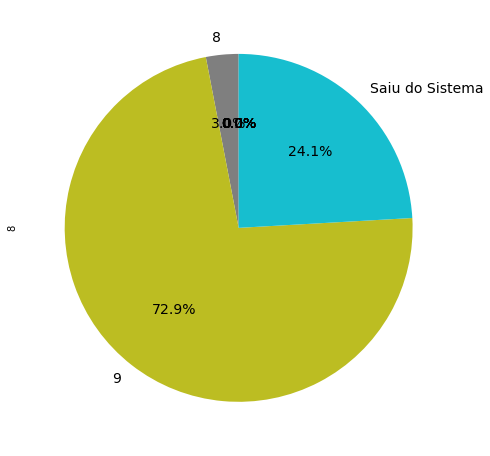

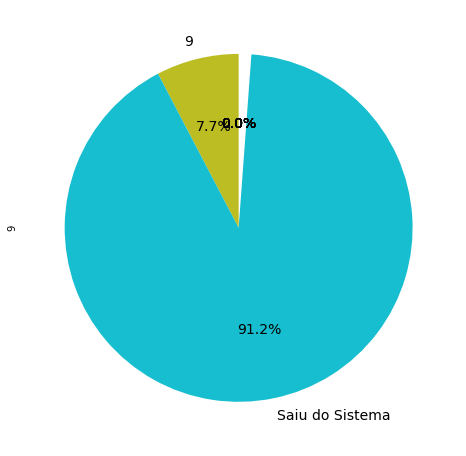

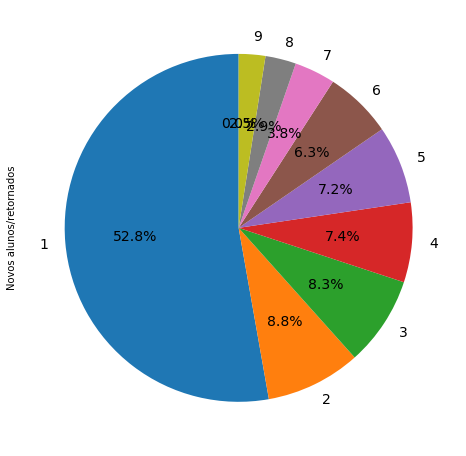

In [227]:
for row in perc_transition.index:
    plt.figure(figsize=(16,8))
    # plot chart
    ax1 = plt.subplot(aspect='equal')
    perc_transition.loc[row, :'Saiu do Sistema'].plot(kind = 'pie', ax = ax1, autopct = '%1.1f%%', 
        startangle = 90, shadow = False, labels = perc_transition.columns[:-1], legend = False, fontsize = 14)
    plt.show()

In [205]:
transition['Saiu do Sistema']/transition['Total of 2016']

1                          0.110449
2                          0.100891
3                          0.089867
4                          0.105563
5                          0.537031
6                          0.163960
7                          0.182699
8                          0.240976
9                          0.911573
Novos alunos/retornados    0.000000
Total of 2017                   inf
dtype: float64

In [204]:
transition.to_csv('matriz de transição', encoding='latin1', sep=';', index = False)

# ML

In [240]:
mat.head()

,Anos_de_Atraso,CO_MUNICIPIO,CO_PESSOA_FISICA,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,NU_ANO,NU_ANO_CENSO,TP_COR_RACA,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_SEXO,TP_TIPO_TURMA,TP_ZONA_RESIDENCIAL,etapa,idade_calculada,Evasao
231084,2.0,3303302,122416481249,0.0,1.0,2005,2016,1,3,1,2,0,1,4.0,11,0
231085,1.0,3303302,121659669498,0.0,1.0,2006,2016,3,3,1,2,0,1,4.0,10,0
231086,1.0,3303302,121427324378,0.0,1.0,2006,2016,3,3,1,2,0,1,4.0,10,0
231087,5.0,3303302,119568471382,0.0,1.0,2002,2016,3,3,1,2,0,1,4.0,14,0
231088,0.0,3303302,119739497097,0.0,1.0,2007,2016,1,3,1,2,0,1,4.0,9,0


In [241]:
matriculas['rep'] = 0
for i in mat['CO_PESSOA_FISICA'].unique(): #for each unique student id
    try: #the row is going to be the grade the student was in 2016
        row = int(mat.loc[(mat['CO_PESSOA_FISICA'] == i) & (mat['NU_ANO_CENSO'] == 2016), 'etapa'])
    except: #if the student can't be found in 2016 then he's a new student
        continue
    try: #the column is going to be the grade the student was in 2017
        column = int(mat.loc[(mat['CO_PESSOA_FISICA'] == i) & (mat['NU_ANO_CENSO'] == 2017), 'etapa'])
    except: #if the student can't be found in 2017 then he left
        column = 'Saiu do Sistema'
    if column == row:
        orig_row = mat[(mat['CO_PESSOA_FISICA'] == i) & (mat['NU_ANO_CENSO'] == 2017)].index[0]
        matriculas.loc[orig_row, 'rep'] = 1

In [247]:
mat_train = matriculas[matriculas['NU_ANO_CENSO'] == 2017].copy()

In [248]:
mat_train.head()

,Anos_de_Atraso,CO_MUNICIPIO,CO_PESSOA_FISICA,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,NU_ANO,NU_ANO_CENSO,TP_COR_RACA,TP_DEPENDENCIA,TP_LOCALIZACAO,TP_SEXO,TP_TIPO_TURMA,TP_ZONA_RESIDENCIAL,etapa,idade_calculada,Evasao,rep
23677,1.0,3303302,121340347775,0.0,1.0,2005,2017,2,3,1,1,0,1,6.0,12,0,0
23865,1.0,3303302,117953400889,0.0,1.0,2004,2017,3,3,1,1,0,1,7.0,13,1,0
23953,0.0,3303302,116649263809,0.0,1.0,2005,2017,2,3,1,2,0,1,7.0,12,0,0
24016,0.0,3303302,150025080813,0.0,1.0,2006,2017,0,3,1,2,0,1,6.0,11,1,0
24017,0.0,3303302,150032352670,0.0,1.0,2006,2017,0,3,1,1,0,1,6.0,11,1,0


In [253]:
mat_train['Brancos'] = 0
mat_train.loc[(mat_train['TP_COR_RACA'] == 1) | (mat_train['TP_COR_RACA'] == 4), 'Brancos'] = 1
mat_train['Feminino'] = 0
mat_train.loc[mat_train['TP_SEXO'] == 2, 'Feminino'] = 1
mat_train['Rural'] = 0
mat_train.loc[mat_train['TP_ZONA_RESIDENCIAL'] == 2, 'Rural'] = 1
mat_train['prom'] = 1 - mat_train['Evasao'] - mat_train['rep']

In [254]:
mat_train.head()

,Anos_de_Atraso,CO_MUNICIPIO,CO_PESSOA_FISICA,IN_ESPECIAL_EXCLUSIVA,IN_REGULAR,NU_ANO,NU_ANO_CENSO,TP_COR_RACA,TP_DEPENDENCIA,TP_LOCALIZACAO,...,TP_TIPO_TURMA,TP_ZONA_RESIDENCIAL,etapa,idade_calculada,Evasao,rep,Brancos,Feminino,Rural,prom
23677,1.0,3303302,121340347775,0.0,1.0,2005,2017,2,3,1,...,0,1,6.0,12,0,0,0,0,0,1
23865,1.0,3303302,117953400889,0.0,1.0,2004,2017,3,3,1,...,0,1,7.0,13,1,0,0,0,0,0
23953,0.0,3303302,116649263809,0.0,1.0,2005,2017,2,3,1,...,0,1,7.0,12,0,0,0,1,0,1
24016,0.0,3303302,150025080813,0.0,1.0,2006,2017,0,3,1,...,0,1,6.0,11,1,0,0,1,0,0
24017,0.0,3303302,150032352670,0.0,1.0,2006,2017,0,3,1,...,0,1,6.0,11,1,0,0,0,0,0


In [255]:
X_cols = ['Anos_de_Atraso', 'etapa', 'idade_calculada', 'Brancos', 'Feminino', 'Rural']
Y_cols = ['Evasao', 'rep', 'prom']

## Decision Tree

In [271]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn import svm
from sklearn.calibration import CalibratedClassifierCV

In [263]:
mat_train['classe'] = mat_train['Evasao'] + 2*mat_train['rep'] + 3*mat_train['prom']

In [264]:
mat_train['classe'].unique()

array([3, 1, 2], dtype=int64)

In [265]:
X = mat_train[X_cols]
Y = mat_train['classe']

In [273]:
classifier = svm.LinearSVC()
clf = CalibratedClassifierCV(classifier) 
clf.fit(X, Y)
y_score = clf.predict_proba(X)

In [274]:
y_score

array([[0.10065309, 0.04237238, 0.85697452],
       [0.06891684, 0.03731892, 0.89376424],
       [0.07182222, 0.01326688, 0.9149109 ],
       ...,
       [0.4010066 , 0.05376235, 0.54523105],
       [0.2095424 , 0.04826977, 0.74218783],
       [0.40895284, 0.06906416, 0.52198299]])

In [278]:
previsoes = pd.DataFrame(y_score, columns = ['Probabilidade de Evasão', 'Probabilidade de Repetência', 'Probabilidade de Promoção'])

In [287]:
previsoes = (previsoes*100).round()

In [295]:
resultado_CE = pd.concat([mat_train.reset_index(drop = True), previsoes], axis=1)

In [296]:
resultado_CE.columns

Index(['Anos_de_Atraso', 'CO_MUNICIPIO', 'CO_PESSOA_FISICA',
       'IN_ESPECIAL_EXCLUSIVA', 'IN_REGULAR', 'NU_ANO', 'NU_ANO_CENSO',
       'TP_COR_RACA', 'TP_DEPENDENCIA', 'TP_LOCALIZACAO', 'TP_SEXO',
       'TP_TIPO_TURMA', 'TP_ZONA_RESIDENCIAL', 'etapa', 'idade_calculada',
       'Evasao', 'rep', 'Brancos', 'Feminino', 'Rural', 'prom', 'classe',
       'Probabilidade de Evasão', 'Probabilidade de Repetência',
       'Probabilidade de Promoção'],
      dtype='object')

In [304]:
resultado_CE['Raça/Cor'] = 'Branco'
resultado_CE.loc[resultado_CE['TP_COR_RACA'] == 0, 'Raça/Cor'] = 'Não Declarada'
resultado_CE.loc[resultado_CE['TP_COR_RACA'] == 2, 'Raça/Cor'] = 'Preta'
resultado_CE.loc[resultado_CE['TP_COR_RACA'] == 3, 'Raça/Cor'] = 'Parda'
resultado_CE.loc[resultado_CE['TP_COR_RACA'] == 4, 'Raça/Cor'] = 'Amarela'
resultado_CE.loc[resultado_CE['TP_COR_RACA'] == 5, 'Raça/Cor'] = 'Indígena'
resultado_CE['Sexo'] = 'Feminino'
resultado_CE.loc[resultado_CE['Feminino'] == 0,'Sexo'] = 'Masculino'
resultado_CE['Zona Residencial'] = 'Urbana'
resultado_CE.loc[resultado_CE['Rural'] == 1,'Zona Residencial'] = 'Rural'

In [306]:
sel_col = ['Anos_de_Atraso', 'CO_PESSOA_FISICA', 'NU_ANO', 'Raça/Cor', 'etapa', 'idade_calculada', 'Sexo', 'Zona Residencial', 
           'Evasao', 'rep', 'prom', 'Probabilidade de Evasão', 'Probabilidade de Repetência', 'Probabilidade de Promoção']

In [309]:
resultado_CE[sel_col].to_csv('resultado_CE.csv', encoding = 'latin1', sep = ';', index = False)

In [311]:
resultado_CE[sel_col].head()

,Anos_de_Atraso,CO_PESSOA_FISICA,NU_ANO,Raça/Cor,etapa,idade_calculada,Sexo,Zona Residencial,Evasao,rep,prom,Probabilidade de Evasão,Probabilidade de Repetência,Probabilidade de Promoção
0,1.0,121340347775,2005,Preta,6.0,12,Masculino,Urbana,0,0,1,10.0,4.0,86.0
1,1.0,117953400889,2004,Parda,7.0,13,Masculino,Urbana,1,0,0,7.0,4.0,89.0
2,0.0,116649263809,2005,Preta,7.0,12,Feminino,Urbana,0,0,1,7.0,1.0,91.0
3,0.0,150025080813,2006,Não Declarada,6.0,11,Feminino,Urbana,1,0,0,10.0,1.0,88.0
4,0.0,150032352670,2006,Não Declarada,6.0,11,Masculino,Urbana,1,0,0,11.0,2.0,88.0


In [312]:
resultado_CE['Raça/Cor'].unique()

array(['Preta', 'Parda', 'Não Declarada', 'Branco', 'Amarela', 'Indígena'],
      dtype=object)

In [313]:
resultado_CE['Sexo'].unique()

array(['Masculino', 'Feminino'], dtype=object)

In [314]:
resultado_CE['Zona Residencial'].unique()

array(['Urbana', 'Rural'], dtype=object)

# Prova Brasil

In [315]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
pb_path = 'D:\\documents\\idados 30 do 5 de 2018\\Eficiencia\\base incompleta\\'
pb = pd.read_stata(pb_path + 'Prova Brasil.dta')

In [9]:
pb.head()

,id_prova_brasil,Estado,id_municipio,id_escola,id_dependencia_adm,Rural,pc_formacao_docente_inicial,pc_formacao_docente_final,Nivel_Socio_Economico,nu_matriculados_censo_5ef,...,nivel_5_mt9,nivel_6_mt9,nivel_7_mt9,nivel_8_mt9,nivel_9_mt9,media_5ef_lp,media_5ef_mt,media_9ef_lp,media_9ef_mt,in_preenchimento_questionario
0,2015,RO,1100015,11024828,3,Urbana,85.400002,38.900002,MÃ©dio,29.0,...,NaN,NaN,NaN,NaN,NaN,199.460007,215.880005,NaN,NaN,1
1,2015,RO,1100015,11024666,3,Rural,85.400002,63.900002,MÃ©dio,21.0,...,NaN,NaN,NaN,NaN,NaN,203.610001,220.929993,NaN,NaN,1
2,2015,RO,1100023,11007605,3,Rural,48.099998,46.200001,MÃ©dio,86.0,...,5.24,2.42,0.0,0.0,0.0,187.899994,202.699997,254.809998,248.589996,1
3,2015,RO,1100023,11007508,3,Urbana,89.500000,49.200001,MÃ©dio,106.0,...,NaN,NaN,NaN,NaN,NaN,208.210007,217.149994,NaN,NaN,1
4,2015,RO,1100023,11007346,3,Rural,40.000000,39.099998,MÃ©dio,23.0,...,9.09,4.55,0.0,0.0,0.0,187.580002,203.320007,249.250000,248.399994,1


In [10]:
pb = pb[pb['id_municipio'] == 3303302]

In [11]:
pb.columns

Index(['id_prova_brasil', 'Estado', 'id_municipio', 'id_escola',
       'id_dependencia_adm', 'Rural', 'pc_formacao_docente_inicial',
       'pc_formacao_docente_final', 'Nivel_Socio_Economico',
       'nu_matriculados_censo_5ef', 'nu_presentes_5ef',
       'taxa_participacao_5ef', 'nivel_0_lp5', 'nivel_1_lp5', 'nivel_2_lp5',
       'nivel_3_lp5', 'nivel_4_lp5', 'nivel_5_lp5', 'nivel_6_lp5',
       'nivel_7_lp5', 'nivel_8_lp5', 'nivel_9_lp5', 'nivel_0_mt5',
       'nivel_1_mt5', 'nivel_2_mt5', 'nivel_3_mt5', 'nivel_4_mt5',
       'nivel_5_mt5', 'nivel_6_mt5', 'nivel_7_mt5', 'nivel_8_mt5',
       'nivel_9_mt5', 'nivel_10_mt5', 'nu_matriculados_censo_9ef',
       'nu_presentes_9ef', 'taxa_participacao_9ef', 'nivel_0_lp9',
       'nivel_1_lp9', 'nivel_2_lp9', 'nivel_3_lp9', 'nivel_4_lp9',
       'nivel_5_lp9', 'nivel_6_lp9', 'nivel_7_lp9', 'nivel_8_lp9',
       'nivel_0_mt9', 'nivel_1_mt9', 'nivel_2_mt9', 'nivel_3_mt9',
       'nivel_4_mt9', 'nivel_5_mt9', 'nivel_6_mt9', 'nivel_7_mt9',
  

In [12]:
cols = ['id_escola', 'Rural', 'Nivel_Socio_Economico', 'media_5ef_lp', 'media_5ef_mt',
       'media_9ef_lp', 'media_9ef_mt']

In [13]:
pb[cols].head()

,id_escola,Rural,Nivel_Socio_Economico,media_5ef_lp,media_5ef_mt,media_9ef_lp,media_9ef_mt
22815,33173540,Urbana,,207.660004,218.029999,NaN,NaN
22816,33056382,Urbana,MÃ©dio Alto,208.139999,218.699997,NaN,NaN
22817,33056463,Urbana,MÃ©dio Alto,215.899994,227.020004,NaN,NaN
22818,33056641,Urbana,MÃ©dio Alto,209.660004,217.550003,NaN,NaN
22819,33056706,Urbana,MÃ©dio Alto,200.070007,205.860001,NaN,NaN


# Georeferenciamento de escolas

In [14]:
lat_lon = pd.read_csv('escolas_niteroi_clean.csv', encoding = 'latin1')
del lat_lon['Unnamed: 0']

In [15]:
lat_lon.head()

,Localiza?Æo,Depend?ncia Administrativa,Nome da Escola,C¢digo da Escola,LATITUDE,LONGITUDE
0,Urbana,Municipal,UMEI HERMOGENES REIS,33055238.0,-22.876874,-43.048181
1,Urbana,Municipal,UMEI ALBERTO BRANDAO,33056323.0,-22.856393,-43.497078
2,Urbana,Municipal,E E DOM JOSE PEREIRA ALVES,33056366.0,-22.880247,-43.092182
3,Urbana,Municipal,E M DEMENCIANO ANTONIO DE MOURA,33056374.0,-22.883286,-43.101755
4,Urbana,Municipal,E M DR ANTONIO COUTINHO DE AZEVEDO,33056382.0,-22.876874,-43.048181


In [16]:
escolas = pd.merge(pb[cols], lat_lon, left_on = 'id_escola', right_on = 'C¢digo da Escola')

In [17]:
escolas

,id_escola,Rural,Nivel_Socio_Economico,media_5ef_lp,media_5ef_mt,media_9ef_lp,media_9ef_mt,Localiza?Æo,Depend?ncia Administrativa,Nome da Escola,C¢digo da Escola,LATITUDE,LONGITUDE
0,33173540,Urbana,,207.660004,218.029999,NaN,NaN,Urbana,Municipal,ESCOLA MUNICPAL PROFESSOR DARIO DE SOUZA CASTELO,33173540.0,-22.948201,-43.032399
1,33056382,Urbana,MÃ©dio Alto,208.139999,218.699997,NaN,NaN,Urbana,Municipal,E M DR ANTONIO COUTINHO DE AZEVEDO,33056382.0,-22.876874,-43.048181
2,33056463,Urbana,MÃ©dio Alto,215.899994,227.020004,NaN,NaN,Urbana,Municipal,E M JACINTA MEDELA,33056463.0,-22.878710,-43.091940
3,33056641,Urbana,MÃ©dio Alto,209.660004,217.550003,NaN,NaN,Urbana,Municipal,E M ADELINO MAGALHAES,33056641.0,-22.874011,-43.094448
4,33056706,Urbana,MÃ©dio Alto,200.070007,205.860001,NaN,NaN,Urbana,Municipal,E M DR ALBERTO FRANCISCO TORRES,33056706.0,-22.895175,-43.115691
5,33056749,Urbana,MÃ©dio Alto,197.559998,208.229996,NaN,NaN,Urbana,Municipal,E M INFANTE DOM HENRIQUE,33056749.0,-22.871645,-43.094177
6,33056838,Urbana,MÃ©dio Alto,216.440002,218.809998,NaN,NaN,Urbana,Municipal,E M NS DA PENHA,33056838.0,-22.881186,-43.122023
7,33056897,Urbana,MÃ©dio Alto,208.919998,221.220001,NaN,NaN,Urbana,Municipal,E M SEBASTIANA GONCALVES PINHO,33056897.0,-22.890022,-43.089056
8,33056935,Urbana,MÃ©dio Alto,214.110001,220.559998,NaN,NaN,Urbana,Municipal,E M VERA LUCIA MACHADO,33056935.0,-22.905562,-43.047851
9,33057800,Urbana,MÃ©dio Alto,209.839996,217.389999,245.199997,249.570007,Urbana,Municipal,E M FRANCISCO PORTUGAL NEVES,33057800.0,-22.942330,-43.055254


In [18]:
escolas['media_5ef_lp'].isnull().sum()

3

In [19]:
escolas[~escolas['media_9ef_mt'].isnull()]

,id_escola,Rural,Nivel_Socio_Economico,media_5ef_lp,media_5ef_mt,media_9ef_lp,media_9ef_mt,Localiza?Æo,Depend?ncia Administrativa,Nome da Escola,C¢digo da Escola,LATITUDE,LONGITUDE
9,33057800,Urbana,MÃ©dio Alto,209.839996,217.389999,245.199997,249.570007,Urbana,Municipal,E M FRANCISCO PORTUGAL NEVES,33057800.0,-22.942330,-43.055254
16,33146640,Urbana,MÃ©dio Alto,216.100006,228.839996,251.710007,255.970001,Urbana,Municipal,E M PAULO FREIRE,33146640.0,-22.882915,-43.082587
25,33056862,Urbana,MÃ©dio Alto,NaN,NaN,248.309998,252.889999,Urbana,Municipal,E M RACHIDE DA GLORIA SALIM SAKER,33056862.0,-22.876095,-43.049109
30,33056790,Urbana,MÃ©dio Alto,214.270004,223.759995,252.259995,257.579987,Urbana,Municipal,E M MAESTRO HEITOR VILLA LOBOS,33056790.0,-22.872956,-43.115018
31,33056773,Urbana,MÃ©dio Alto,206.910004,213.990005,244.699997,248.199997,Urbana,Municipal,E M LEVI CARNEIRO,33056773.0,-22.902470,-43.063654
32,33056765,Urbana,MÃ©dio Alto,198.419998,210.690002,236.179993,240.919998,Urbana,Municipal,E M JOSE DE ANCHIETA,33056765.0,-22.888210,-43.064409
33,33056757,Urbana,MÃ©dio Alto,198.080002,208.979996,226.210007,235.690002,Urbana,Municipal,E M JOAO BRAZIL,33056757.0,-22.869497,-43.068567
34,33056730,Urbana,MÃ©dio Alto,NaN,NaN,256.839996,261.690002,Urbana,Municipal,E M HONORINA DE CARVALHO,33056730.0,-22.883611,-43.025818
39,33056650,Urbana,Alto,NaN,NaN,260.619995,271.109985,Urbana,Municipal,ESCOLA MUNICIPAL ALTIVO CESAR,33056650.0,-22.863126,-43.097219


In [20]:
escolas_red = escolas.loc[~escolas['media_5ef_mt'].isnull(), ['id_escola', 'media_5ef_mt', 'LATITUDE', 'LONGITUDE']]
escolas_red.to_csv('escolas_red.csv', index = False)

In [21]:
escolas_red.head()

,id_escola,media_5ef_mt,LATITUDE,LONGITUDE
0,33173540,218.029999,-22.948201,-43.032399
1,33056382,218.699997,-22.876874,-43.048181
2,33056463,227.020004,-22.878710,-43.091940
3,33056641,217.550003,-22.874011,-43.094448
4,33056706,205.860001,-22.895175,-43.115691


In [23]:
escolas_red['media_5ef_mt'].mean()/500

0.43977664184570314

In [378]:
import gmaps

ModuleNotFoundError: No module named 'gmaps'

In [364]:
from mpl_toolkits.basemap import Basemap

ModuleNotFoundError: No module named 'mpl_toolkits.basemap'

In [366]:
spath = 'C:\\Users\\magme\\Documents\\HackNit\\Escolas_Municipais_de_Ensino_Fundamental_EM'
sname = 'Escolas_Municipais_de_Ensino_Fundamental_EM'

<IPython.core.display.Javascript object>


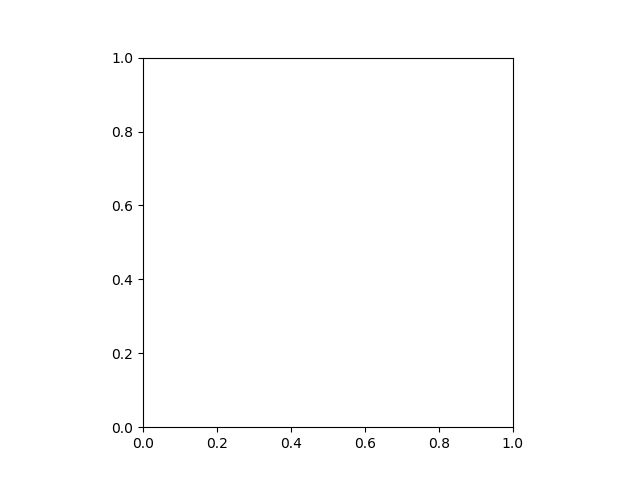

<IPython.core.display.Javascript object>


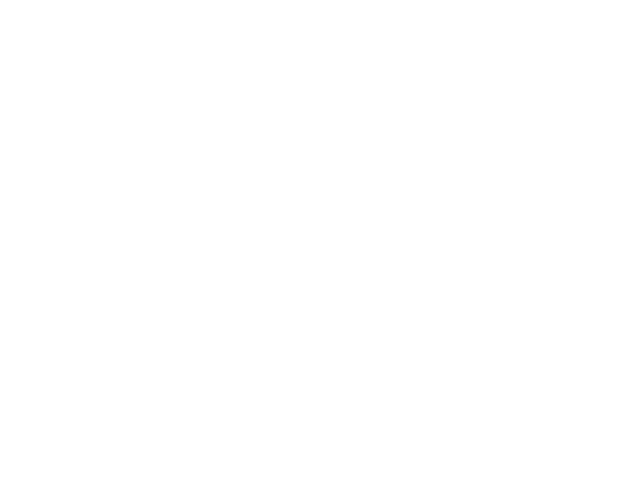

In [361]:
map = Basemap(resolution = 'i', projection = 'tmerc', lat_0 = -22.53, lon_0 = -43.06)

map.drawmapboundary(fill_color = 'aqua')
map.fillcontinents(color = '#ddaa66', lake_color = 'aqua')
map.drawcoastlines()

map.readshapefile(spath, 'Escolas_Municipais_de_Ensino_Fundamental_EM')

x = escolas_red.LONGITUDE
y = escolas_red.LATITUDE
colors = np.random.rand(len(escolas_red))
area = escolas_red.media_5ef_mt
plt.scatter(x, y, s = area*50, c = colors, alpha = 0.5)

plt.show()

In [ ]:
x = agg.LONGITUDE
y = agg.LATITUDE
colors = np.random.rand(len(agg))
area=agg.QTD_ALUNOS_COLETADOS
plt.figure()
plt.scatter(x,y,s=area*50,c=colors,alpha=0.5)
plt.show()

# Avaliação do Municipio

In [24]:
resultado_CE_red = pd.read_csv('resultado_CE.csv', encoding = 'latin1', sep = ';')

In [25]:
resultado_CE_red.head()

,Anos_de_Atraso,CO_PESSOA_FISICA,NU_ANO,Raça/Cor,etapa,idade_calculada,Sexo,Zona Residencial,Evasao,rep,prom,Probabilidade de Evasão,Probabilidade de Repetência,Probabilidade de Promoção
0,1.0,121340347775,2005,Preta,6.0,12,Masculino,Urbana,0,0,1,10.0,4.0,86.0
1,1.0,117953400889,2004,Parda,7.0,13,Masculino,Urbana,1,0,0,7.0,4.0,89.0
2,0.0,116649263809,2005,Preta,7.0,12,Feminino,Urbana,0,0,1,7.0,1.0,91.0
3,0.0,150025080813,2006,Não Declarada,6.0,11,Feminino,Urbana,1,0,0,10.0,1.0,88.0
4,0.0,150032352670,2006,Não Declarada,6.0,11,Masculino,Urbana,1,0,0,11.0,2.0,88.0


In [34]:
n = len(resultado_CE_red[resultado_CE_red['etapa'] < 9])
eva = resultado_CE_red.loc[resultado_CE_red['etapa'] < 9, 'Evasao'].sum()
rep = resultado_CE_red.loc[resultado_CE_red['etapa'] < 9, 'rep'].sum()

In [36]:
eva/n

0.2554736842105263

In [37]:
rep/n

0.09242105263157895

In [35]:
rep

1756

In [33]:
eva

4854

In [31]:
n

19000